In [263]:
# Generic libraries
import numpy as np
import pandas as pd
import scipy as sp
import tqdm
import seaborn as sns
from itertools import product
import inspect
import multiprocessing
import time
import os
import glob
import ipympl

from ipywidgets import *
%matplotlib notebook
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mtick
from collections import namedtuple
from tabulate import tabulate
from IPython.display import Latex
from IPython.display import HTML
from IPython.core.pylabtools import figsize
from matplotlib import rc


In [264]:
# MDAnalysis
import MDAnalysis as mda
from MDAnalysis.analysis.rms import rmsd
from MDAnalysis.analysis.rms import RMSF
from MDAnalysis.analysis import diffusionmap, align, rms
from MDAnalysis.coordinates.base import Timestep
from MDAnalysis.analysis import contacts
from MDAnalysis.lib import distances
from MDAnalysis.analysis.base import analysis_class
from MDAnalysis.lib.distances import capped_distance, self_capped_distance
from MDAnalysis.lib.distances import distance_array, self_distance_array
import MDAnalysis.analysis.hydrogenbonds as hb

In [265]:
## autocorrelation estimate
def autocorrelation(x):
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    #r = np.array([(x[:n-k]*x[-(n-k):]).sum() for k in range(n)]) #slow method using the definition
    r = np.correlate(x, x, mode = 'full')[-n:] # fast method, same result!
    result = r/(variance*(np.arange(n, 0, -1)))
    return result

In [266]:
## Import common data (e.g. pdb and psf files)
from pathlib import Path
simdir = Path('../data/00-external/')
PDB = simdir / '5Y36.pdb'
GRO = simdir / '5Y36_box.gro'

# set paths for output
plotpath = "../plots/"
datapath = "../data/analysis/"
output_name = "prod_global_"


In [267]:
## import full trajectory data 
trajdir = '../data/04-prod/'
XTC  = trajdir + 'cas9_prod_pbc_all.xtc'

## universe creation
u = mda.Universe(str(GRO), str(XTC))
#u_new = u.copy() # used as a reference in memory for mapping calculations
#ref0 = mda.Universe(str(GRO))
print(u.select_atoms("protein or name MG").n_atoms, 'protein atoms')

# other info
box = u.dimensions
print('box dimensions:', box)
nframes = u.trajectory.n_frames
print(nframes, 'frames')
dt = u.trajectory.dt # ns per frame, equal to nstxout*0.002
dt_ns = dt / 1000
time = np.arange(0, dt*nframes, dt)
t_ns = time / 1000
print(t_ns[-1], 'ns')


22526 protein atoms
box dimensions: [183.38486  183.38486  183.38478   60.000008  60.000008  90.      ]
7301 frames
365.0 ns


## RMSD



In [273]:

stride = 1
reduced_index = list(range(0, nframes, stride))
ref_start = [u.select_atoms('protein and name CA').positions for ts in u.trajectory[0:1]][0]

rmsd_ca = [rmsd(u.select_atoms('protein and name CA').positions, ref_start, \
                  center=True, superposition=True) for ts in u.trajectory[reduced_index]]

rmsd_ca = np.array(rmsd_ca[1:-1])


<IPython.core.display.Javascript object>


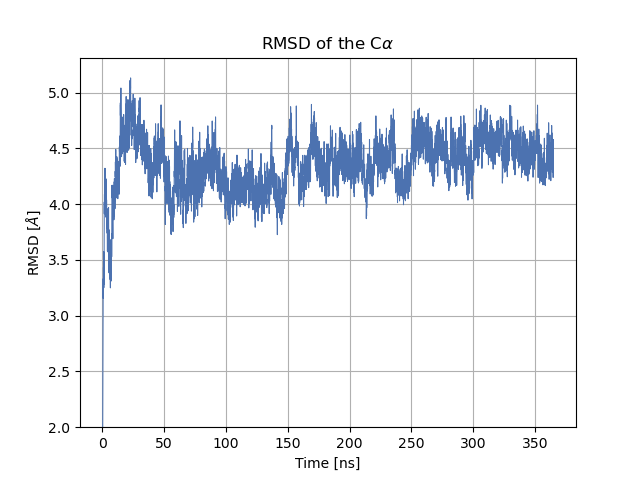

In [274]:
# plot of the backbone RMSD
fig = plt.figure()

plt.plot(t_ns[stride:-1:stride], rmsd_ca, lw=0.75)

plt.xlabel('Time [ns]')
plt.ylabel(r'RMSD [$\AA$]')
plt.title(r'RMSD of the C$\alpha$')
plt.ylim(bottom=2)
plt.grid()
#plt.legend()
#plt.autoscale(tight=True)
plt.show()
plt.savefig(os.path.join(plotpath, output_name+'rmsd_protein.pdf'))

<IPython.core.display.Javascript object>


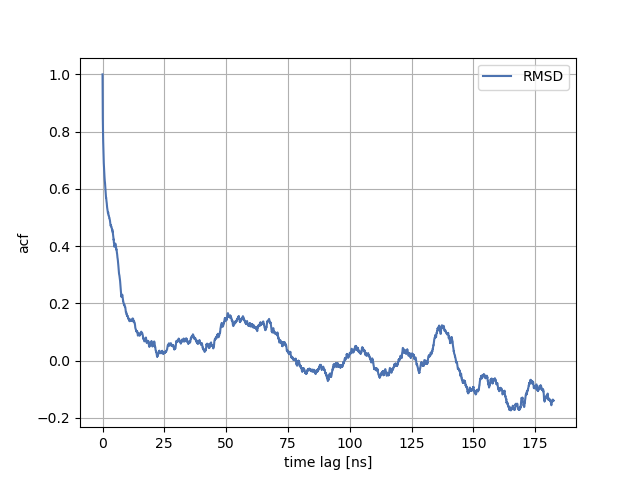

In [275]:
t_acf = t_ns[0:len(t_ns)//(2*stride)-1] * stride 
acf = autocorrelation(rmsd_ca)[0:len(rmsd_ca)//2]

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(t_acf, acf, label=r"RMSD")
plt.xlabel("time lag [ns]")
plt.ylabel("acf")
plt.grid()
plt.legend()
plt.show()
plt.savefig(os.path.join(plotpath, output_name+'_rmsd_acf.pdf'))

#### RMSD after 156ns

4181
156.0


<IPython.core.display.Javascript object>


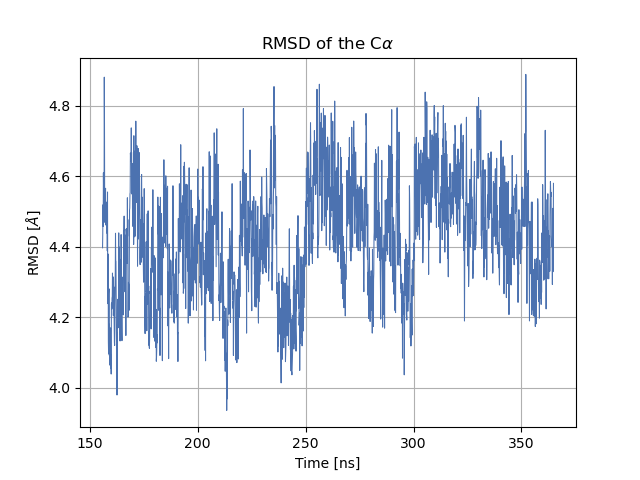

In [312]:
startframe = 3120
print(nframes-startframe)
print(startframe*dt_ns)

# plot of the backbone RMSD
fig = plt.figure()

plt.plot(t_ns[startframe//stride:-3:2], rmsd_ca[startframe//stride:-1:2], lw=0.75)

plt.xlabel('Time [ns]')
plt.ylabel(r'RMSD [$\AA$]')
plt.title(r'RMSD of the C$\alpha$')
#plt.ylim(bottom=2)
plt.grid()
#plt.legend()
#plt.autoscale(tight=True)
plt.show()
plt.savefig(os.path.join(plotpath, output_name+'rmsd_ca_cut.pdf'))

43.00636039700301


<IPython.core.display.Javascript object>


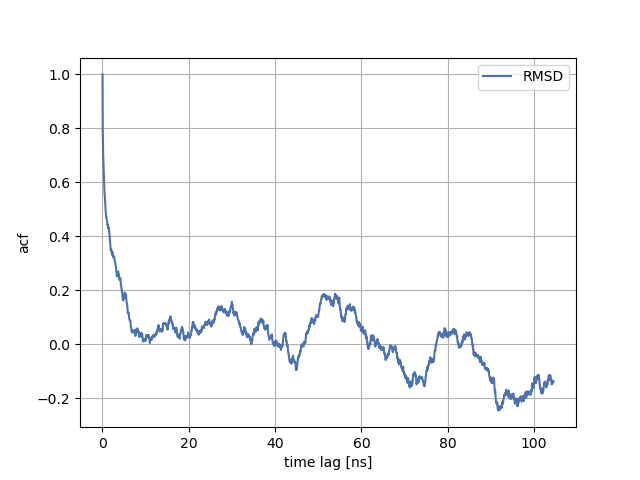

In [278]:

t_acf = t_ns[1:(len(t_ns)-startframe)//(2*stride)] * stride  
acf = autocorrelation(rmsd_ca[startframe:-1])[0:(len(rmsd_ca)-startframe)//2]
act = sum(acf[0:len(acf)//10])
print(act)

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(t_acf, acf, label=r"RMSD")
plt.xlabel("time lag [ns]")
plt.ylabel("acf")
plt.grid()
plt.legend()
plt.show()
plt.savefig(os.path.join(plotpath, output_name+'_rmsd_acf_cut.pdf'))

In [279]:
## RMSD of the DNA and RNA phosphates (not really useful since parts of these are outside of the protein)
stride = 1
reduced_index = list(range(1, nframes, stride))

ref_start = [u.select_atoms('(nucleic and name P)').positions \
             for ts in u.trajectory[0:1]][0]

rmsd_bn = [rmsd(u.select_atoms('(nucleic and name P)').positions, ref_start, \
                  center=True, superposition=True) for ts in u.trajectory[reduced_index]]


<IPython.core.display.Javascript object>


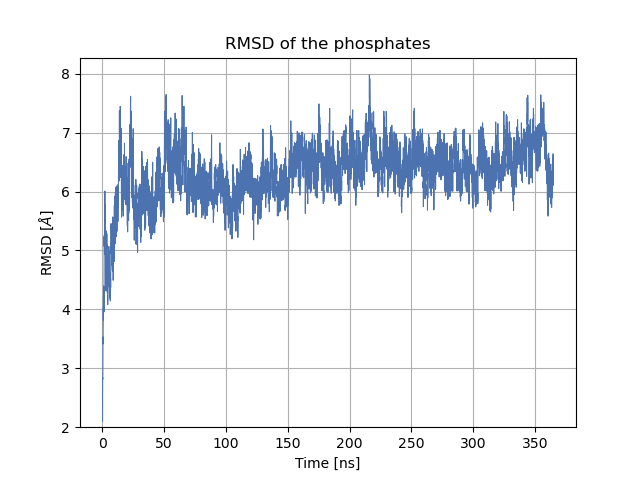

In [280]:
fig = plt.figure()

plt.plot(t_ns[stride:-1:stride], rmsd_bn[0:-1], lw=0.75)

plt.xlabel('Time [ns]')
plt.ylabel(r'RMSD [$\AA$]')
plt.title(r'RMSD of the phosphates')
plt.ylim(bottom=2)
plt.grid()
#plt.legend()
plt.show()
plt.savefig(os.path.join(plotpath, output_name+'rmsd_nucleic.pdf'))

### RMSD of  interesting protein domains

## RMSD 2D Map

In [281]:
step = 5
aligner = align.AlignTraj(u, u, select='name CA', in_memory=True).run()
matrix = diffusionmap.DistanceMatrix(u, select='name CA').run(start=0, step=step)

<IPython.core.display.Javascript object>


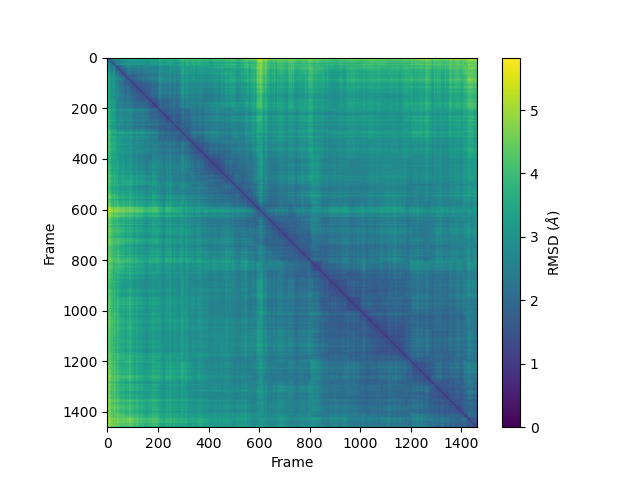

In [282]:
plt.figure()
plt.imshow(matrix.results.dist_matrix, cmap='viridis')
plt.xlabel('Frame')
plt.ylabel('Frame')
plt.colorbar(label=r'RMSD ($\AA$)')
plt.savefig(os.path.join(plotpath, output_name+'rmsd_map.pdf'))
plt.show()

1410


<IPython.core.display.Javascript object>


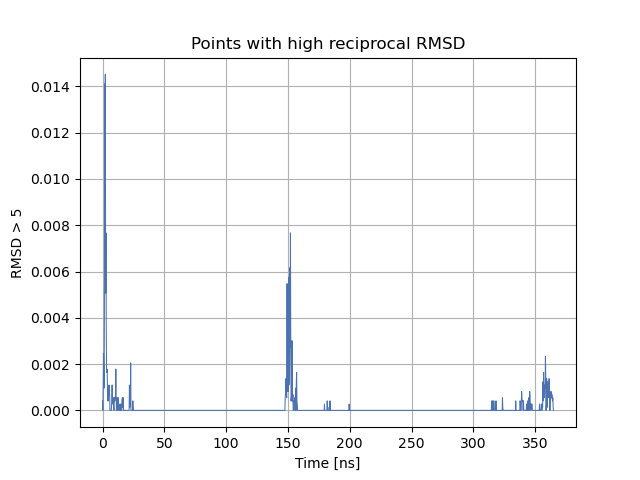

In [283]:
bool_arr = matrix.results.dist_matrix>5.0
high_rmsd_positions = np.where(bool_arr)[0]
print(len(high_rmsd_positions))
sum_rmsd = np.sum(bool_arr, axis=1) / nframes

plt.figure()
plt.clf()
plt.plot(t_ns[0:-1:step], sum_rmsd[0:-1], lw=0.75)
plt.xlabel('Time [ns]')
plt.ylabel(r'RMSD > 5')
plt.title(r'Points with high reciprocal RMSD')
plt.grid()
#plt.legend()
plt.show()


TODO check what happens at 150ns by comparing averaged 2 frames

## RMSF


$$RMSF_i = \left[\frac{1}{T}\sum_{t_j=1}^T |\mathbf{r}_i(t_j)-\mathbf{r}_i|^2\right]^{1/2}$$


In [284]:
from MDAnalysis.analysis.rms import RMSF
from MDAnalysis.analysis import align
from MDAnalysis.coordinates.memory import MemoryReader
from MDAnalysis.analysis.base import AnalysisFromFunction

In [285]:
average = align.AverageStructure(u, u, select='protein and name CA', ref_frame=1).run()
ref = average.results.universe
aligner = align.AlignTraj(u, ref, select='protein and name CA', in_memory=True).run()

In [286]:
c_alphas = u.select_atoms('protein and name CA')
R = rms.RMSF(c_alphas, verbose=True).run()

  0%|          | 0/7301 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


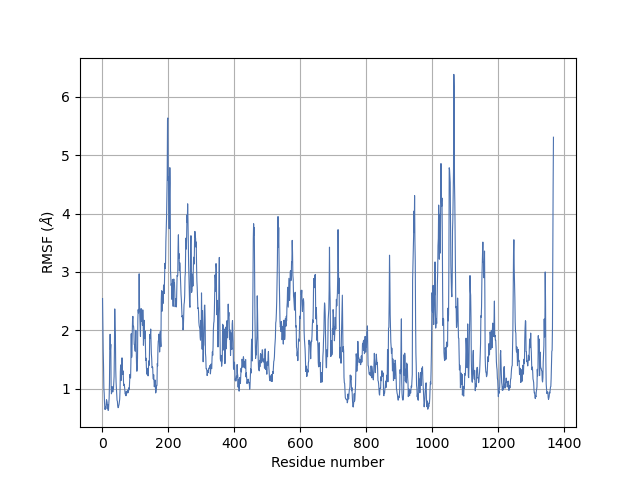

In [287]:
fig2 = plt.figure()
plt.plot(c_alphas.resids, R.results.rmsf, lw=0.8)
plt.xlabel('Residue number')
plt.ylabel('RMSF ($\AA$)')
#plt.axvspan(30, 59, zorder=0, alpha=0.2, color='green', label='NMP')
#plt.legend();
plt.grid();
plt.show()
plt.savefig(os.path.join(plotpath, output_name+'rmsf_ca.pdf'))

In [288]:
bool_arr = R.results.rmsf>4
high_rmsf_positions = np.where(bool_arr)[0]
print(high_rmsf_positions)

[ 195  196  197  198  199  200  201  203  204  205  258  944  946 1019
 1025 1026 1027 1028 1029 1051 1052 1053 1054 1063 1064 1065 1066 1067
 1068 1366 1367]


In [289]:
u.add_TopologyAttr('tempfactors') # add empty attribute for all atoms
protein = u.select_atoms('protein') # select protein atoms
for residue, r_value in zip(protein.residues, R.results.rmsf):
    residue.atoms.tempfactors = r_value
    #print(residue.atoms.tempfactors)

In [290]:
# suppress some MDAnalysis warnings about writing PDB files
import warnings
warnings.filterwarnings('ignore')
# save pdb with beta factor data
u.atoms.write(os.path.join(datapath, 'rmsf_tempfactors0-40.pdb')) #writes pdb with the beta factors to analysis

In [291]:
import nglview as nv
view = nv.show_mdanalysis(u)
view.update_representation(color_scheme='bfactor')
view

NGLWidget(max_frame=7300)

In [292]:
rmsf1 = RMSF(c_alphas, start=1, stop=nframes//4).run(start=1, stop=nframes//4)
rmsf2 = RMSF(c_alphas, start=nframes//4, stop=nframes//2).run(start=nframes//4, stop=nframes//2)
rmsf3 = RMSF(c_alphas, start=nframes//2, stop=3*nframes//4).run(start=nframes//2, stop=3*nframes//4)
rmsf4 = RMSF(c_alphas, start=3*nframes//4, stop=nframes-1).run(start=3*nframes//4, stop=nframes-1)

<IPython.core.display.Javascript object>


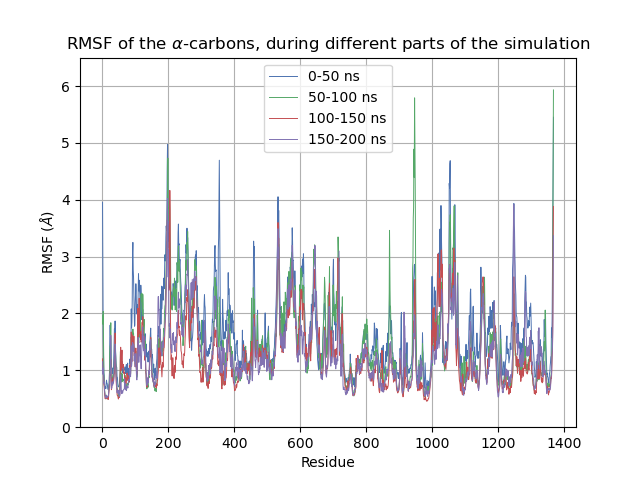

In [293]:
fig = plt.figure()
plt.plot(c_alphas.resnums, rmsf1.results.rmsf, lw=0.7, label='0-50 ns')
plt.plot(c_alphas.resnums, rmsf2.results.rmsf, lw=0.7, label='50-100 ns')
plt.plot(c_alphas.resnums, rmsf3.results.rmsf, lw=0.7, label='100-150 ns')
plt.plot(c_alphas.resnums, rmsf4.results.rmsf, lw=0.7, label='150-200 ns')
#plt.axvline(x=59, color='r', lw=0.8)
plt.ylim(top=6.5, bottom=0)
#plt.xlim(left=0)
plt.xlabel('Residue')
plt.ylabel('RMSF ($\AA$)')
plt.title(r'RMSF of the $\alpha$-carbons, during different parts of the simulation')
plt.grid()
plt.legend(loc=0)
plt.show()
plt.savefig(os.path.join(plotpath, output_name+'rmsf_part.pdf'))

In [311]:
bool_arr = rmsf4.results.rmsf>3.5
high_rmsf_positions = np.where(bool_arr)[0]
print(high_rmsf_positions)

[ 196  197 1246 1247]


#### average_prot = align.AverageStructure(u, u, select='protein', ref_frame=1).run()
ref_prot = average_prot.results.universe

In [296]:
# Save aligned trajectory
aligner = align.AlignTraj(u, ref_prot,
                           select='protein',
                           filename='./data/analysis/aligned_prot.dcd',
                           in_memory=False).run()
prot_al = u.select_atoms("protein")
prot_al.write(os.path.join(datapath,'aligned_prot.xtc'), frames='all')


## Radius of gyration

$$R_\mathrm{gyr} = \sqrt{\frac{1}{M}\sum_{i=1}^{N} m_i(\mathbf{r}_i - \mathbf{R})^2}$$

In [297]:
stride = 1
Rgyr = []
ca = u.select_atoms("protein and name CA")
for ts in u.trajectory[0:nframes:stride]:
   Rgyr.append(ca.radius_of_gyration())
Rgyr = np.array(Rgyr)

rel_diff = (max(Rgyr) - min(Rgyr))/10
print(len(ca))

1368


<IPython.core.display.Javascript object>


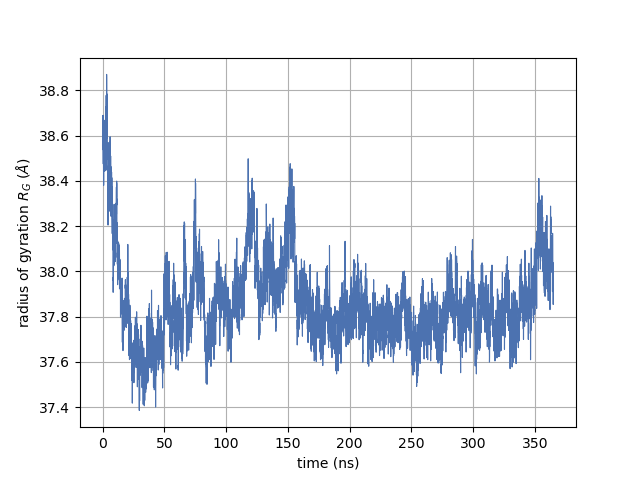

In [298]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(t_ns[0:nframes:stride], Rgyr, lw=0.8, label=r"$R_G$")
ax.set_xlabel("time (ns)")
ax.set_ylabel(r"radius of gyration $R_G$ ($\AA$)")
plt.grid()
plt.show()
ax.figure.savefig(plotpath+output_name+"Rgyr_ca.pdf")

<IPython.core.display.Javascript object>


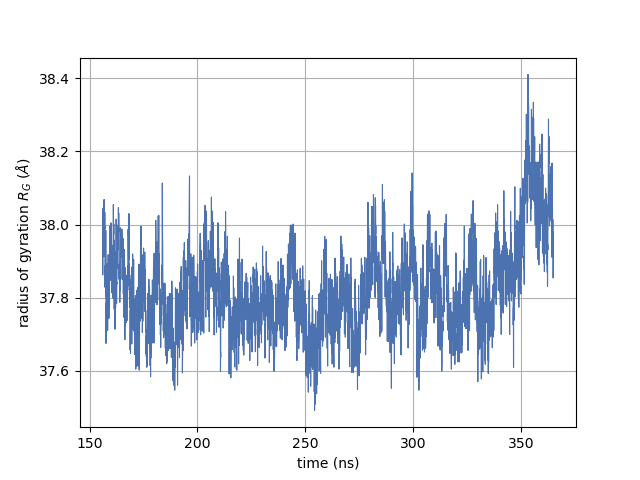

In [299]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(t_ns[3120:nframes-1:stride], Rgyr[3120:-1], lw=0.8, label=r"$R_G$")
ax.set_xlabel("time (ns)")
ax.set_ylabel(r"radius of gyration $R_G$ ($\AA$)")
plt.grid()
plt.show()
ax.figure.savefig(plotpath+output_name+"Rgyr_ca.pdf")

<IPython.core.display.Javascript object>


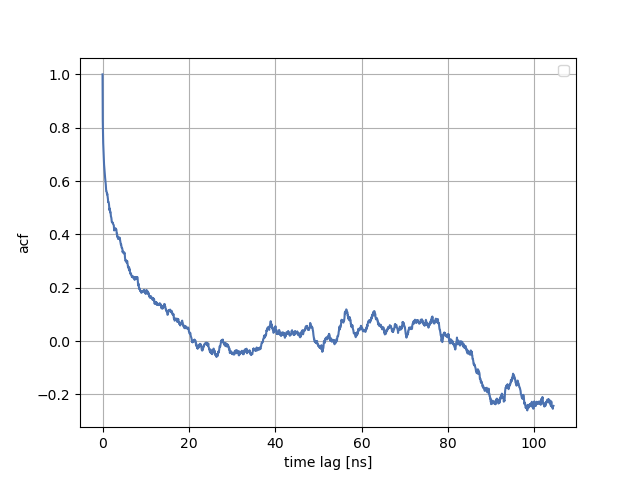

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [300]:
startframe = 3120

t_acf = t_ns[0:(len(t_ns)-startframe)//(2*stride)] * stride  
acf = autocorrelation(Rgyr[startframe:-1])[0:(len(Rgyr)-startframe)//2]
act = sum(acf[0:len(acf)//6])

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(t_acf, acf)
plt.xlabel("time lag [ns]")
plt.ylabel("acf")
plt.grid()
plt.legend()
plt.show()
plt.savefig(os.path.join(plotpath, output_name+'_rgyr_acf.pdf'))

In [301]:
act

90.43214229949493

In [302]:
def blocked(universe, u_selection, nblocks, startframe, analyze):
    size = (universe.trajectory.n_frames - startframe) // nblocks
    blocks_avg = []
    blocks_std = []
    
    for block in range(nblocks):
        val = []
        for ts in universe.trajectory[startframe + block * size : startframe + (block + 1) * size]:
            val.append(analyze(u_selection))
        blocks_avg.append(np.average(val))
        blocks_std.append(np.std(val))
    blockaverage = np.average(blocks_avg)
    #blockstd = np.std(blocks)
    blockstd = np.average(blocks_std)

    return nblocks, size, blockaverage, blockstd


In [303]:
def rgyr(selection):
    return selection.radius_of_gyration()


In [ ]:
Rgyrtest = []
ca = u.select_atoms("protein and name CA")
for ts in u.trajectory[1:50:1]:
   Rgyrtest.append(rgyr(ca))
Rgyrtest = np.array(Rgyrtest)
Rgyrtest

In [ ]:
rgyr_5blocks = blocked(u, ca, 5, rgyr)
rgyr_5blocks

In [313]:
startframe = 3120
#nblocks_array = [10,12,14,16,18,20,25,30,40,50,60,70,80,100,120,140,160,180,200,220]
nblocks_array = [25,30,40,50,65,80,100,150,200,300,400,600,800,1000,1300,1500]
results = []
for nblocks in nblocks_array:
    results.append(blocked(u, ca, nblocks, startframe, rgyr))
rg = np.array(results)

In [314]:
block_lengths = (nframes-startframe) / np.array(nblocks_array)

rg[:,3]

array([0.08806409, 0.08378498, 0.08203967, 0.07978338, 0.07643373,
       0.07515503, 0.07212853, 0.06674418, 0.06457381, 0.05904818,
       0.05616629, 0.0490271 , 0.04737509, 0.04336992, 0.03773955,
       0.02817484])

<IPython.core.display.Javascript object>


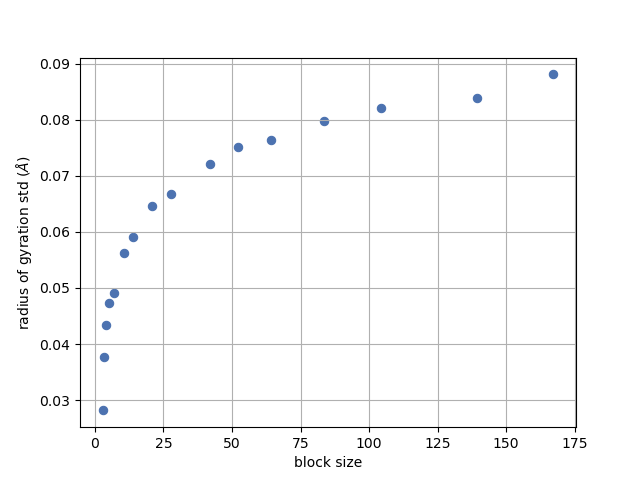

In [315]:
fig = plt.figure()
ax = plt.subplot(111)
ax.scatter(block_lengths, rg[:,3], lw=0.8, label=r"$R_G$")
ax.set_xlabel("block size")
ax.set_ylabel(r"radius of gyration std ($\AA$)")
plt.grid()
plt.show()


In [ ]:
100*dt_ns

<IPython.core.display.Javascript object>


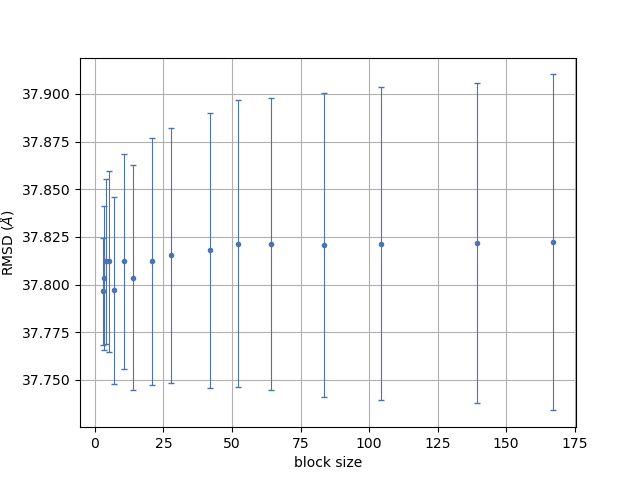

In [316]:
fig = plt.figure()
ax = plt.subplot(111)
ax.errorbar(block_lengths, rg[:,2], rg[:,3], lw=0.8, marker='.', label=r"$RMSD$", capsize=2.5, linestyle='')
ax.set_xlabel("block size")
ax.set_ylabel(r"RMSD ($\AA$)")
plt.grid()
plt.show()


In [ ]:
ref_start = [u.select_atoms('protein and name CA').positions for ts in u.trajectory[0:1]][0]

def rmsd_block(selection):
    return rmsd(selection.positions, ref_start, center=True, superposition=True)

startframe = 3100
nblocks_array = [12,16,20,30,40,50,60,70,80,100,120,140,160,180,200,220]


In [ ]:
results = []
for nblocks in nblocks_array:
    results.append(blocked(u, ca, nblocks, startframe, rmsd_block))
rmsd = np.array(results)

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)
ax.errorbar(block_lengths, rmsd[:,2], rmsd[:,3], lw=0.8, marker='.', label=r"$RMSD$", capsize=2.5, linestyle='')
ax.set_xlabel("block size")
ax.set_ylabel(r"RMSD ($\AA$)")
plt.grid()
plt.show()
